In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf

In [40]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [41]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")
df['year'] = df['caldt'].dt.strftime("%Y")

# df = df[df['caldt'] >= '2000-01-01']

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year
3534200,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023
3534201,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023
3534202,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023
3534203,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023
3534204,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023


In [42]:
# Generate features from the last 12 months

formation_period = 12 # months

# 1 month sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None)

# Log 1 months sales growth
df['log_sg'] = np.log(1+df['sg'])

# Past 1 year log sales growth
df[f'log_sg_{formation_period}'] = df.groupby('permno').rolling(formation_period,formation_period)['log_sg'].sum().reset_index(drop=True)

df.tail()

/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrew/Projects/Quant/mean_reversion/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12
3534200,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436
3534201,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436
3534202,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436
3534203,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436
3534204,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436


In [43]:
# Generate target variable

# Log 1 month return
df['log_ret'] = np.log(1 + df['ret'])

holding_period = 12 # months

# 12 month holding period return
df[f'ret_{holding_period}'] = df.groupby('permno').rolling(holding_period,holding_period)['log_ret'].sum().reset_index(drop=True)
df[f'ret_{holding_period}'] = df.groupby('permno')[f'ret_{holding_period}'].shift(-(holding_period-1))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_12
3534200,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,NaN
3534201,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,NaN
3534202,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,NaN
3534203,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,NaN
3534204,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,NaN


In [44]:
# Lag all formation variables by 1 month
df['ep_lag'] = df.groupby('permno')['ep'].shift(1) 
df['sg_lag'] = df.groupby('permno')[f'log_sg_{formation_period}'].shift(1)
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)

# Remove stocks that don't have formation variables and low priced stocks
df = df.query("ep_lag == ep_lag and sg_lag == sg_lag and prc_lag >= 5").reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,year,sg,log_sg,log_sg_12,log_ret,ret_12,ep_lag,sg_lag,prc_lag
1980402,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,2023,0.0,0.0,0.414436,-0.035588,NaN,0.032216,0.414436,267.429993
1980403,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,2023,0.0,0.0,0.414436,-0.030929,NaN,0.032216,0.414436,258.079987
1980404,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,2023,0.0,0.0,0.414436,-0.219832,NaN,0.032216,0.414436,250.220001
1980405,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,2023,0.0,0.0,0.414436,0.178464,NaN,0.032216,0.414436,200.839996
1980406,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,2023,0.0,0.0,0.414436,0.034390,NaN,0.032216,0.414436,240.080002


In [45]:
# Create quantiles based off of b/m lag and sales growth lag
df['ep_bins'] = df.groupby("mdt")['ep_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))
df['sg_bins'] = df.groupby("mdt")['sg_lag'].transform(lambda x: pd.qcut(x, 3, labels=False))

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,...,sg,log_sg,log_sg_12,log_ret,ret_12,ep_lag,sg_lag,prc_lag,ep_bins,sg_bins
1980402,2023-08-31,93436.0,0.114912,0.032216,81462.0,8.191443e+08,258.079987,-0.034962,2023-08,08,...,0.0,0.0,0.414436,-0.035588,NaN,0.032216,0.414436,267.429993,1,2
1980403,2023-09-30,93436.0,0.114912,0.032216,81462.0,7.954494e+08,250.220001,-0.030456,2023-09,09,...,0.0,0.0,0.414436,-0.030929,NaN,0.032216,0.414436,258.079987,1,2
1980404,2023-10-31,93436.0,0.114912,0.032216,81462.0,6.384545e+08,200.839996,-0.197346,2023-10,10,...,0.0,0.0,0.414436,-0.219832,NaN,0.032216,0.414436,250.220001,1,2
1980405,2023-11-30,93436.0,0.114912,0.032216,81462.0,7.631954e+08,240.080002,0.195379,2023-11,11,...,0.0,0.0,0.414436,0.178464,NaN,0.032216,0.414436,200.839996,1,2
1980406,2023-12-31,93436.0,0.114912,0.032216,81462.0,7.898983e+08,248.479996,0.034988,2023-12,12,...,0.0,0.0,0.414436,0.034390,NaN,0.032216,0.414436,240.080002,1,2


In [46]:
# Create portfolio dataframe with only january month data
port = df[df['month'] == '01'].copy()

# Group stocks by year and bins
port = port.groupby(['year', 'ep_bins', 'sg_bins'])[f'ret_{holding_period}'].mean().unstack(level=['ep_bins', 'sg_bins'])

# Drop rows with no holding period returns
port = port.dropna()

# Value portfolio is high ep and low sg
# Glamor portfolio is low ep and high sg
# Create a spread portfolio with long value and short glamor stocks
port['spread'] = port[2][0] - port[0][2]

port.tail()

ep_bins         0                             1                             2  \
sg_bins         0         1         2         0         1         2         0   
year                                                                            
2019     0.047927  0.148885  0.131118  0.170356  0.230574  0.198455  0.113186   
2020     0.132098  0.128996  0.239697 -0.002437  0.069206  0.049783 -0.018364   
2021     0.064518  0.032594 -0.182281  0.188612  0.209736  0.149563  0.257946   
2022    -0.317386 -0.462941 -0.731707 -0.164702 -0.200100 -0.358756 -0.129956   
2023    -0.076710  0.029330  0.009913  0.107662  0.095074  0.106652  0.031947   

ep_bins                        spread  
sg_bins         1         2            
year                                   
2019     0.196407  0.144109 -0.017931  
2020    -0.030082 -0.059989 -0.258061  
2021     0.251053  0.301968  0.440226  
2022    -0.126793 -0.180949  0.601751  
2023     0.122551  0.141114  0.022033

In [47]:
# Portfolio summary table

(summary(port).loc[['count','mean','std','tstat']] * 100).round(3)

ep_bins         0                             1                             2  \
sg_bins         0         1         2         0         1         2         0   
count    6600.000  6600.000  6600.000  6600.000  6600.000  6600.000  6600.000   
mean       -0.699     1.182    -5.163     7.512     8.418     3.310     9.603   
std        26.329    22.046    29.129    18.110    18.300    23.116    20.525   
tstat     -21.566    43.575  -143.998   336.960   373.708   116.332   380.102   

ep_bins                        spread  
sg_bins         1         2            
count    6600.000  6600.000  6600.000  
mean       10.292     6.551    14.766  
std        19.381    23.224    18.945  
tstat     431.406   229.156   633.215

In [48]:
# Create backtest with yearly returns

backtest_y = port.copy()
backtest_y.index = pd.to_datetime(backtest_y.index)
backtest_y['cum_ret'] = backtest_y['spread'].cumsum()

backtest_y.tail()

ep_bins            0                             1                      \
sg_bins            0         1         2         0         1         2   
year                                                                     
2019-01-01  0.047927  0.148885  0.131118  0.170356  0.230574  0.198455   
2020-01-01  0.132098  0.128996  0.239697 -0.002437  0.069206  0.049783   
2021-01-01  0.064518  0.032594 -0.182281  0.188612  0.209736  0.149563   
2022-01-01 -0.317386 -0.462941 -0.731707 -0.164702 -0.200100 -0.358756   
2023-01-01 -0.076710  0.029330  0.009913  0.107662  0.095074  0.106652   

ep_bins            2                        spread   cum_ret  
sg_bins            0         1         2                      
year                                                          
2019-01-01  0.113186  0.196407  0.144109 -0.017931  8.939746  
2020-01-01 -0.018364 -0.030082 -0.059989 -0.258061  8.681685  
2021-01-01  0.257946  0.251053  0.301968  0.440226  9.121911  
2022-01-01 -0.129956 -0.126793 -0.180949  0.601751  9.723663  
2023-01-01  0.031947  0.122551  0.141114  0.022033  9.745696

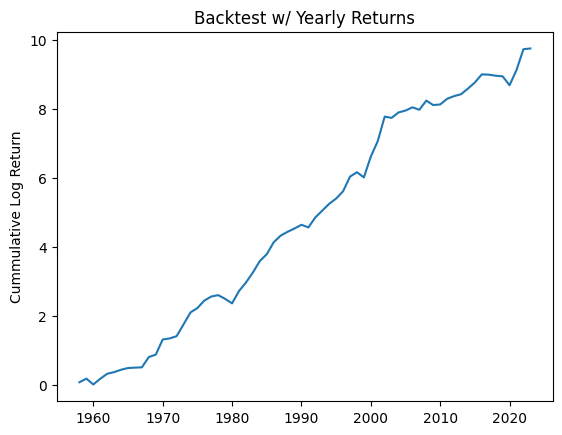

In [49]:
plt.plot(backtest_y.index,backtest_y['cum_ret'])
plt.title("Backtest w/ Yearly Returns")
plt.ylabel("Cummulative Log Return")
plt.show()

In [50]:
# Create backtest with monthly returns

backtest_m = df.groupby(['mdt','ep_bins','sg_bins'])['log_ret'].mean().unstack(level=['ep_bins','sg_bins'])

backtest_m['spread'] = backtest_m[2][0] - backtest_m[0][2]

backtest_m = backtest_m.dropna()

backtest_m = backtest_m['spread'].reset_index()

backtest_m = backtest_m.rename(columns={'spread': 'log_ret'})

backtest_m['cum_ret'] = backtest_m['log_ret'].cumsum()

backtest_m['caldt'] = pd.to_datetime(backtest_m['mdt'])

backtest_m

,mdt,log_ret,cum_ret,caldt
0,1957-08,0.014620,0.014620,1957-08-01
1,1957-09,0.021965,0.036584,1957-09-01
2,1957-10,-0.001689,0.034896,1957-10-01
3,1957-11,-0.032475,0.002421,1957-11-01
4,1957-12,-0.003820,-0.001399,1957-12-01
...,...,...,...,...
792,2023-08,0.034265,9.777665,2023-08-01
793,2023-09,0.040966,9.818631,2023-09-01
794,2023-10,0.074662,9.893293,2023-10-01
795,2023-11,-0.030193,9.863100,2023-11-01


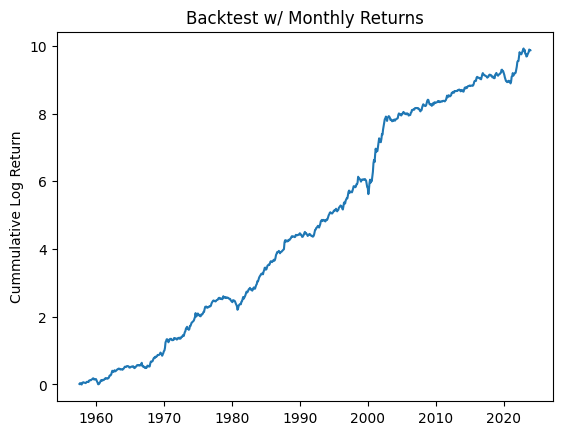

In [51]:
plt.plot(backtest_m['caldt'], backtest_m['cum_ret'])
plt.title("Backtest w/ Monthly Returns")
plt.ylabel("Cummulative Log Return")
plt.show()

In [52]:
# Calculate sharpe ratio using monthly returns

numerator = backtest_m['log_ret'].mean()
denominator = backtest_m['log_ret'].std()
scale = 12 / np.sqrt(12)

sharpe = numerator / denominator * scale

print(f"Sharpe Ratio of {round(sharpe,2)}")

Sharpe Ratio of 1.01


### 5 Factor Model Decomposition

In [53]:
fac = pd.read_csv("~/Data/fama_5_factors.csv")

fac

,DATE,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...
729,202404,-4.67,-2.56,-0.52,1.48,-0.30,0.47
730,202405,4.34,0.76,-1.66,2.98,-3.07,0.44
731,202406,2.77,-4.37,-3.31,0.51,-1.78,0.41
732,202407,1.24,8.28,5.73,0.22,0.43,0.45


In [54]:
fac['mdt'] = pd.to_datetime(fac['DATE'].astype(str), format='%Y%m').dt.strftime("%Y-%m")
fac

,DATE,Mkt-RF,SMB,HML,RMW,CMA,RF,mdt
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11
...,...,...,...,...,...,...,...,...
729,202404,-4.67,-2.56,-0.52,1.48,-0.30,0.47,2024-04
730,202405,4.34,0.76,-1.66,2.98,-3.07,0.44,2024-05
731,202406,2.77,-4.37,-3.31,0.51,-1.78,0.41,2024-06
732,202407,1.24,8.28,5.73,0.22,0.43,0.45,2024-07


In [55]:
merge = pd.merge(backtest_m, fac, on='mdt', how='inner')

merge = merge.drop(columns=['cum_ret', 'caldt', 'DATE'])

merge['log_ret'] = merge['log_ret'] * 100

merge = merge.rename(columns={'Mkt-RF': 'MKT'})

merge

,mdt,log_ret,MKT,SMB,HML,RMW,CMA,RF
0,1963-07,-0.081622,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,1963-08,-2.228003,5.07,-0.80,1.80,0.36,-0.35,0.25
2,1963-09,1.582213,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,1963-10,-1.009687,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,1963-11,-0.237427,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...,...
721,2023-08,3.426530,-2.39,-3.68,-1.08,3.42,-2.37,0.45
722,2023-09,4.096567,-5.24,-1.79,1.45,1.85,-0.84,0.43
723,2023-10,7.466208,-3.18,-4.05,0.19,2.47,-0.67,0.47
724,2023-11,-3.019306,8.83,-0.11,1.66,-3.81,-0.99,0.44


In [56]:
model = smf.ols("log_ret ~ MKT + SMB + HML + RMW + CMA", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     646.7
Date:                Mon, 07 Oct 2024   Prob (F-statistic):          2.05e-263
Time:                        17:50:12   Log-Likelihood:                -1486.1
No. Observations:                 726   AIC:                             2984.
Df Residuals:                     720   BIC:                             3012.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9673      0.073     13.258      0.000       0.824       1.111
MKT           -0.2480      0.017    -14.202      0.000      -0.282      -0.214
SMB           -0.1783      0.026     -6.988      0.000      -0.228      -0.128
HML            0.7722      0.033     23.660      0.000       0.708       0.836
RMW            0.6086      0.034     17.699      0.000       0.541       0.676
CMA            0.3999      0.049      8.097      0.000       0.303       0.497
==============================================================================
Omnibus:                       17.185   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.802
Skew:                           0.143   Prob(JB):                     3.38e-07
Kurtosis:                       3.950   Cond. No.                         5.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
model = smf.ols("log_ret ~ MKT", data=merge).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     271.0
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           5.81e-52
Time:                        17:50:12   Log-Likelihood:                -1988.9
No. Observations:                 726   AIC:                             3982.
Df Residuals:                     724   BIC:                             3991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5853      0.140     11.299      0.000       1.310       1.861
MKT           -0.5099      0.031    -16.462      0.000      -0.571      -0.449
==============================================================================
Omnibus:                       81.995   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              398.414
Skew:                           0.374   Prob(JB):                     3.06e-87
Kurtosis:                       6.551   Cond. No.                         4.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""